In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
pd.__version__

u'0.22.0'

In [2]:
ls jigsaw

sample_submission.csv      submission2.csv  test.csv      train.csv.zip
sample_submission.csv.zip  submission3.csv  test.csv.zip
submission1.csv            submission4.csv  train.csv


In [3]:
train = pd.read_csv('jigsaw/train.csv')
test = pd.read_csv('jigsaw/test.csv')
train['comment_text'] = train['comment_text'].fillna('')
test['comment_text'] = test['comment_text'].fillna('')

In [4]:
len(train)

95851

In [5]:
len(test)

226998

In [6]:
!head jigsaw/sample_submission.csv -n2

id,toxic,severe_toxic,obscene,threat,insult,identity_hate
6044863,0.5,0.5,0.5,0.5,0.5,0.5


In [7]:
#toxic,severe_toxic,obscene,threat,insult,identity_hate

In [8]:
train.head(1)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,22256635,"Nonsense? kiss off, geek. what I said is true...",1,0,0,0,0,0


In [9]:
train['comment_text'].str.len().min(), train['comment_text'].str.len().max()

(6, 5895)

In [10]:
test['comment_text'].str.len().min(), test['comment_text'].str.len().max()

(0, 2003165)

In [11]:
train['toxic,severe_toxic,obscene,threat,insult,identity_hate'.split(',')].describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,95851.000000,95851.000000,95851.000000,95851.000000,95851.000000,95851.000000
mean,0.096368,0.010068,0.053301,0.003182,0.049713,0.008492
std,0.295097,0.099832,0.224635,0.056320,0.217352,0.091762
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


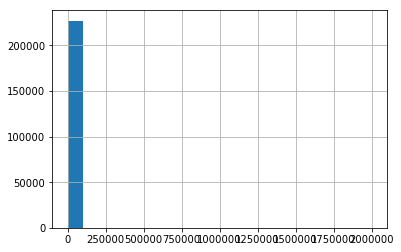

In [12]:
test['comment_text'].str.len().hist(bins=20)

In [13]:
def word_tokenize(text):
    try:
        return nltk.word_tokenize(text)
    except UnicodeDecodeError as e:
        tmp = text.decode('utf-8', errors='replace')
        return nltk.word_tokenize(tmp)
    except Exception as e:
        raise ValueError("Can't decode " + text, e)    

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

In [15]:
from IPython.display import display
for attribute_value in 'toxic,severe_toxic,obscene,threat,insult,identity_hate'.split(','):
    display(train[attribute_value].unique())

array([1, 0])

array([0, 1])

array([0, 1])

array([0, 1])

array([0, 1])

array([0, 1])

In [16]:
vectorizer.fit(train['comment_text'])
vectorizer.fit(test['comment_text'])

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [17]:
train_tokens = vectorizer.fit_transform(train['comment_text'])
train_labels = train['toxic,severe_toxic,obscene,threat,insult,identity_hate'.split(',')].as_matrix()

In [18]:
train_labels.shape, train_tokens.shape

((95851, 6), (95851, 139171))

In [19]:
validation_indexes = np.arange(0, 100)
train_indexes = np.arange(100, 9581)
train_tokens = train_tokens[train_indexes]
train_labels = train_labels[train_indexes]
validation_labels = train_labels[validation_indexes]
validation_tokens = train_tokens[validation_indexes]

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
model = LogisticRegression()
model = OneVsRestClassifier(model)

In [21]:
model.fit(train_tokens, train_labels)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1)

In [22]:
model.score(validation_tokens, validation_labels)

0.98999999999999999

In [23]:
from sklearn.metrics import log_loss
predicted_train_labels = model.predict_proba(train_tokens)
log_loss(train_labels, predicted_train_labels)

0.22765007479970467

In [24]:
predicted_validation_labels = model.predict_proba(validation_tokens)
log_loss(validation_labels, predicted_validation_labels)
# LB is 0.095

0.10920966853562925

In [25]:
test_tokens = vectorizer.transform(test['comment_text'])

In [26]:
test_labels = model.predict_proba(test_tokens)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


In [27]:
results = pd.DataFrame(test_labels, columns='toxic,severe_toxic,obscene,threat,insult,identity_hate'.split(','))
results['id'] = test['id']
results.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,id
0,2.531128e-02,1.339908e-02,0.011919,5.876418e-03,0.050791,0.015602,6044863
1,2.471414e-06,8.016953e-08,0.000020,5.191798e-08,0.000120,0.000003,6102620
2,3.367620e-08,3.135969e-08,0.000006,6.542724e-09,0.000030,0.000002,14563293
3,9.468250e-02,1.089588e-02,0.038112,2.364039e-03,0.044719,0.007481,21086297
4,3.929036e-02,7.517998e-03,0.018483,3.486812e-03,0.030159,0.005264,22982444


In [28]:
from IPython.display import FileLink
results.to_csv('jigsaw/submission1.csv', index=False)
FileLink('jigsaw/submission1.csv')

/home/ubuntu/downloads/jigsaw/submission1.csv

In [29]:
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import Conv1D, BatchNormalization, Dropout, Input, Dense, MaxPooling1D, Embedding, Flatten

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [30]:
test_tokens.shape[1], train_labels.shape[1]

(139171, 6)

In [31]:
train_tokens[3]

<1x139171 sparse matrix of type '<type 'numpy.int64'>'
	with 38 stored elements in Compressed Sparse Row format>

In [32]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(nb_words=100000)
tokenizer.fit_on_texts(train['comment_text'])
tokenizer.fit_on_texts(test['comment_text'])

In [33]:
train_sequences = tokenizer.texts_to_sequences(train['comment_text'])
train_sequences = pad_sequences(train_sequences, maxlen=2000)

In [34]:
train_labels = train['toxic,severe_toxic,obscene,threat,insult,identity_hate'.split(',')].as_matrix()

validation_indexes = np.arange(0, 100)
train_indexes = np.arange(100, 9581)
train_sequences = train_sequences[train_indexes]
train_labels = train_labels[train_indexes]
validation_labels = train_labels[validation_indexes]
validation_sequences = train_sequences[validation_indexes]

In [35]:
input_layer = Input(shape=(train_sequences.shape[1], ))
x = Dense(1000, activation='relu')(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.01)(x)
output_layer = Dense(train_labels.shape[1], activation='sigmoid')(x)
model = Model(input_layer, output_layer)
model.compile(Adam(), loss='binary_crossentropy')

In [36]:
# LB is 0.174
model.fit(train_sequences, train_labels, validation_data=(validation_sequences, validation_labels))

Train on 9481 samples, validate on 100 samples
Epoch 1/10
9481/9481 [==============================] - 2s - loss: 0.2862 - val_loss: 0.1320
Epoch 2/10
9481/9481 [==============================] - 2s - loss: 0.1470 - val_loss: 0.0822
Epoch 3/10
9481/9481 [==============================] - 2s - loss: 0.1308 - val_loss: 0.0895
Epoch 4/10
9481/9481 [==============================] - 2s - loss: 0.1226 - val_loss: 0.0738
Epoch 5/10
9481/9481 [==============================] - 2s - loss: 0.1194 - val_loss: 0.0824
Epoch 6/10
9481/9481 [==============================] - 2s - loss: 0.1150 - val_loss: 0.0780
Epoch 7/10
9481/9481 [==============================] - 2s - loss: 0.1125 - val_loss: 0.0746
Epoch 8/10
9481/9481 [==============================] - 2s - loss: 0.1087 - val_loss: 0.0718
Epoch 9/10
9481/9481 [==============================] - 2s - loss: 0.1076 - val_loss: 0.0682
Epoch 10/10
9481/9481 [==============================] - 2s - loss: 0.1053 - val_loss: 0.0735


In [37]:
test_sequences = tokenizer.texts_to_sequences(test['comment_text'])
test_sequences = pad_sequences(test_sequences, maxlen=2000)

In [38]:
test_labels = model.predict(test_sequences)

In [39]:
from IPython.display import FileLink
results.to_csv('jigsaw/submission2.csv', index=False)
FileLink('jigsaw/submission2.csv')

/home/ubuntu/downloads/jigsaw/submission2.csv

In [40]:
train_sequences.shape

(9481, 2000)

In [48]:
SEQ_LEN=train_sequences.shape[1]
VOCAB_SIZE = 100*1000
input_layer = Input(shape=(SEQ_LEN, ))
x = Embedding(VOCAB_SIZE, 32, input_length=SEQ_LEN)(input_layer)
x = Conv1D(nb_filter = 100, filter_length=3)(x)
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
output_layer = Dense(train_labels.shape[1], activation='sigmoid')(x)
model2 = Model(input_layer, output_layer)
model2.compile(Adam(), loss='binary_crossentropy')

In [49]:
model2.fit(train_sequences, train_labels, validation_data=(validation_sequences, validation_labels), nb_epoch=1)

Train on 9481 samples, validate on 100 samples
Epoch 1/1
9481/9481 [==============================] - 21s - loss: 0.2871 - val_loss: 0.3935


In [50]:
model2.fit(train_sequences, train_labels, validation_data=(validation_sequences, validation_labels), nb_epoch=1)

Train on 9481 samples, validate on 100 samples
Epoch 1/1
9481/9481 [==============================] - 21s - loss: 0.0766 - val_loss: 0.1407


In [ ]:
# LB: 11.490 which is wildly bad (I was using model not model 2 :/)
# LB: 0.25 actually
from IPython.display import FileLink
test_labels = model2.predict(test_sequences)
results = pd.DataFrame(test_labels, columns='toxic,severe_toxic,obscene,threat,insult,identity_hate'.split(','))
results['id'] = test['id']
results.to_csv('jigsaw/submission4_2.csv', index=False)
FileLink('jigsaw/submission4_2.csv')

In [55]:
print("test")

test


In [56]:
ls jigsaw

sample_submission.csv      submission2.csv    submission4.csv  train.csv
sample_submission.csv.zip  submission3.csv    test.csv         train.csv.zip
submission1.csv            submission4_2.csv  test.csv.zip
